In [ ]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!curl -L "https://app.roboflow.com/ds/[GqRnfdLze9mzBCO6Y4Ps]" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    27  100    27    0     0    128      0 --:--:-- --:--:-- --:--:--   128
Archive:  roboflow.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of roboflow.zip or
        roboflow.zip.zip, and cannot find roboflow.zip.ZIP, period.


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="GqRnfdLze9mzBCO6Y4Ps")
project = rf.workspace("rmk-engineering-college").project("tumor-vit")
dataset = project.version(1).download("folder")



loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to tumor-ViT-1 in folder:: 100%|██████████| 2908/2908 [00:00<00:00, 3320.36it/s]


In [ ]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/content/tumor-ViT-1/train', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('/content/tumor-ViT-1/valid', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder('/content/tumor-ViT-1/test', transform=ToTensor())

In [ ]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [ ]:
EPOCHS = 3
BATCH_SIZE = 10
LEARNING_RATE = 2e-5

In [ ]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.


In [ ]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx)

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Train the model
for epoch in range(EPOCHS):
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss = model(b_x, None)
    # Calculate loss
    if loss is None:
      loss = loss_func(output, b_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if step % 50 == 0:
      # Get the next batch for testing purposes
      test = next(iter(test_loader))
      test_x = test[0]
      # Reshape and get feature matrices as needed
      test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
      for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
      test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
      test_x = test_x.to(device)
      test_y = test[1].to(device)
      # Get output (+ respective class) and compare to target
      test_output, loss = model(test_x, test_y)
      test_output = test_output.argmax(1)
      # Calculate Accuracy
      accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

Number of train samples:  2300
Number of test samples:  350
Detected Classes are:  {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Epoch:  0 | train loss: 1.4159 | test accuracy: 0.10
Epoch:  0 | train loss: 1.3497 | test accuracy: 0.20
Epoch:  0 | train loss: 1.3774 | test accuracy: 0.40
Epoch:  0 | train loss: 1.3818 | test accuracy: 0.30
Epoch:  0 | train loss: 1.3927 | test accuracy: 0.00
Epoch:  1 | train loss: 1.3881 | test accuracy: 0.30
Epoch:  1 | train loss: 1.4104 | test accuracy: 0.00
Epoch:  1 | train loss: 1.4370 | test accuracy: 0.00
Epoch:  1 | train loss: 1.3937 | test accuracy: 0.30
Epoch:  1 | train loss: 1.3987 | test accuracy: 0.20
Epoch:  2 | train loss: 1.3948 | test accuracy: 0.10
Epoch:  2 | train loss: 1.3916 | test accuracy: 0.20
Epoch:  2 | train loss: 1.4005 | test accuracy: 0.10
Epoch:  2 | train loss: 1.3808 | test accuracy: 0.30
Epoch:  2 | train loss: 1.3918 | test accuracy: 0.20


torch.Size([1, 3, 224, 224])


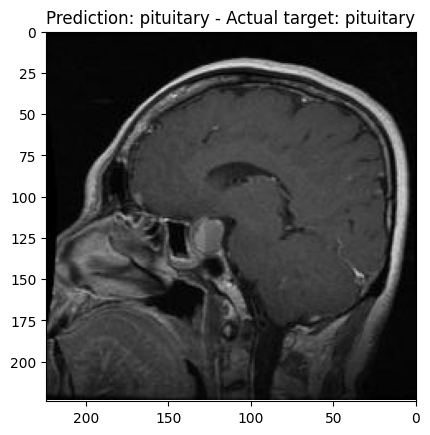

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4)
# Disable grad
with torch.no_grad():

  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)

  # Generate prediction
  prediction, loss = model(inputs, target)

  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]

  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()

In [ ]:
torch.save(model, '/content/ViTmodel1.pt')

In [ ]:
torch.save(model, '/home/ViTmodelsaved.pt')

In [ ]:
MODEL_PATH = '/content/ViTmodel1.pt'
model = torch.load(MODEL_PATH)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
from PIL import Image
image_path = '/Hirnmetastase_MRT-T1_KM.jpg'
image = Image.open(image_path)


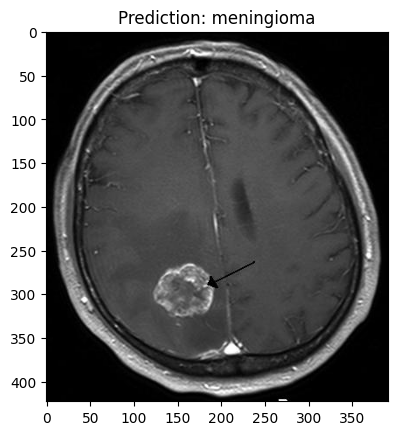

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess the image

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_image = preprocess(image).unsqueeze(0)

# Send the input image to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_image = input_image.to(device)

# Disable grad
with torch.no_grad():
    # Generate prediction
    logits, _ = model(input_image,labels=None)

# Convert prediction to class label
predicted_class_index = torch.argmax(logits, dim=1).item()
predicted_class_label = list(valid_ds.class_to_idx.keys())[predicted_class_index]

# Show result
print(predicted_class_label)
plt.imshow(image)
plt.title(f'Prediction: {predicted_class_label}')
plt.show()
